In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from helper import *

In [2]:
label= "2021-07-08-runs/run"
gid= "0.0"
pop= "PNs"
N= 800
nglo= N//5
spike_t= np.load(label+"_hom_"+gid+"_"+pop+"_spike_t.npy")
spike_ID= np.load(label+"_hom_"+gid+"_"+pop+"_spike_ID.npy")
t_total= spike_t[-1]

In [3]:
mlabel= "2021-07-08-runs/run_hom_0.0_odors_5_99"
mspike_t= np.load(mlabel+"_"+pop+"_spike_t.npy")
mspike_ID= np.load(mlabel+"_"+pop+"_spike_ID.npy")
mt_total= mspike_t[-1]

In [4]:
def force_aspect(ax,aspect):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [5]:
def glo_avg(sdf: np.ndarray, n):
    nglo= sdf.shape[1]//n
    gsdf= np.zeros((sdf.shape[0],nglo))
    for i in range(nglo):
        gsdf[:,i]= np.mean(sdf[:,n*i:n*(i+1)],axis=1)
    return gsdf

In [6]:
sample_t= 6000
cnum= 24
batch_t= cnum*sample_t
wds= int(t_total//batch_t) # corresponds to number of odours presented / number of batches
li= 0
sigma_sdf= 100
dt_sdf= 1
mxsdfs= np.zeros((wds,cnum))
mnsdfs= np.zeros((wds,cnum))
mxid= np.zeros(wds, dtype=int)
mx= np.zeros(wds)
amnsdf=np.zeros((100,24,160))
for i in range(wds):
    meansdf= np.zeros(nglo)
    gsdfs= []
    for j in range(cnum):
        left= i*batch_t+j*sample_t
        right= left+sample_t
        while li < len(spike_t) and spike_t[li] < left:
            li+= 1
        ri= li
        while ri < len(spike_t) and spike_t[ri] < right:
            ri+= 1
        lsdfs= make_sdf(spike_t[li:ri], spike_ID[li:ri], np.arange(0,N), left-3*sigma_sdf, right+3*sigma_sdf, dt_sdf, sigma_sdf)
        gsdfs.append(glo_avg(lsdfs,5))
        meansdf+= np.mean(gsdfs[-1][3000:,:],axis=0)
        amnsdf[i,j,:]= np.mean(gsdfs[-1][3000:,:],axis=0)
    mxid[i]= np.argmax(meansdf)  # this is the strongest glomerulus over all concentrations
    mx[i]= np.amax(meansdf)
    for k in range(cnum):
        mxsdfs[i,k]= np.amax(gsdfs[k][:,mxid[i]],axis=0)
        mnsdfs[i,k]= np.mean(gsdfs[k][3000:,mxid[i]],axis=0)
mxmx= np.argmax(mx)

In [7]:
mono= np.zeros(wds)
for i in range(wds):
    mono[i]= (np.amax(mnsdfs[i,:])-mnsdfs[i,-1])/np.mean(mnsdfs[i,:])
mxmono= np.argmin(mono)

In [8]:
print("Strongest odor is {}.".format(mxmx))
print("Most monotonic odor is {}.".format(mxmono))

Strongest odor is 31.
Most monotonic odor is 89.


[ 63 133  93  25  32 135  93  28   1  35  14   1  89 136  97 106 101 141
  32  93  38  17  26  14  53 110  97  52  55  16 136  29 141 105  26 114
 120  89  65  57  73  93  44  40  35  55 104 126  38  63   0  45  63 115
 102 154  40   1 104  29 105  53  77  93 106 138 136  90  89  59 110 133
 145  49  32  55 129  63  57  81  18 110  34  18  13  75  52  96 136  40
  89 103 149  57 139 104  36  67  49 154]
(100, 160, 2)


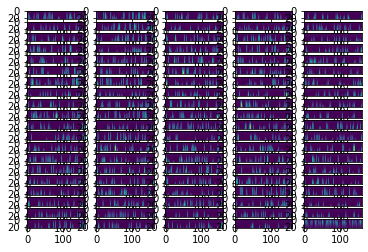

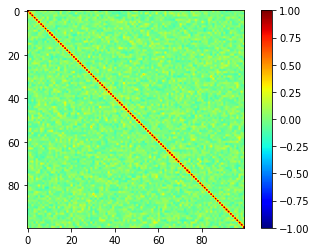

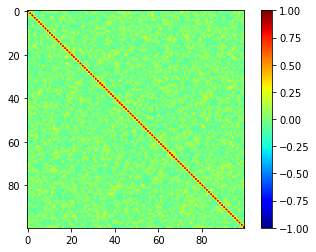

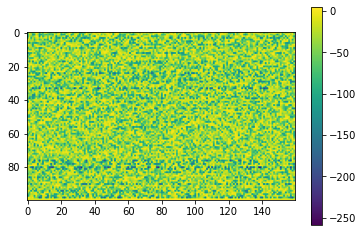

In [9]:
fig, ax= plt.subplots(20,5)
for i in range(20):
    for j in range(5):
        ax[i,j].imshow(np.reshape(amnsdf[i*5+j,:,:],(24,160)))
print(mxid)
cca= np.zeros((100,100))
for i in range(100):
    for j in range(100):
        cc= np.corrcoef(np.reshape(amnsdf[i,-1,:],160),np.reshape(amnsdf[j,-1,:],160))
        cca[i,j]= cc[0,1]
plt.figure()
plt.imshow(cca,cmap="jet", vmin= -1, vmax=1)
plt.colorbar()
odors= np.load("2021-07-02-runs/test_new_odors.npy")
print(odors.shape)
for i in range(100):
    for j in range(100):
        cc= np.corrcoef(np.reshape(odors[i,:,0],160),np.reshape(odors[j,:,0],160))
        cca[i,j]= cc[0,1]
plt.figure()
plt.imshow(cca,cmap="jet", vmin= -1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(np.reshape(np.log(odors[:,:,0]),(100,160)))
plt.colorbar()

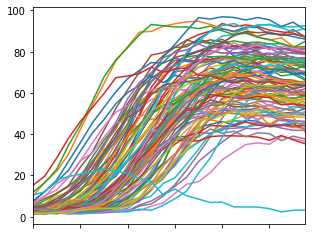

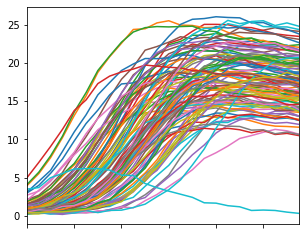

In [10]:
plt.figure()
plt.plot(np.transpose(mxsdfs))
ax= plt.gca()
ax.set_xticks(range(0,24,4))
ax.set_xticklabels([])
ax.set_xlim((0,23))
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*0.8)
plt.savefig("max_sdfs.png",dpi=300)
plt.figure()
plt.plot(np.transpose(mnsdfs))
ax= plt.gca()
ax.set_xlim((0,23))
ax.set_xticks(range(0,24,4))
ax.set_xticklabels([])
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*0.8)
plt.savefig("mean_sdfs.png",dpi=300)

<Figure size 432x288 with 0 Axes>

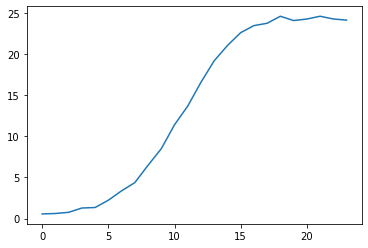

In [11]:
plt.figure()
#plt.imshow(mnsdfs)
#force_aspect(plt.gca(),1.2)
plt.figure()
for i in range(5,6):
    plt.plot(np.transpose(mnsdfs)[:,i])

Display Responses to binary mixtures of the "geosmin odor" and a "normal odor"
===

In [12]:
li= 0
mwds= int(mt_total//batch_t) # corresponds to number of odours presented / number of batches
mmxsdfs= np.zeros((mwds,cnum))
mmnsdfs= np.zeros((mwds,cnum))
aimn= np.zeros((mwds,cnum,nglo))
for i in range(mwds):
    for j in range(cnum):
        left= i*batch_t+j*sample_t
        right= left+sample_t
        while li < len(mspike_t) and mspike_t[li] < left:
            li+= 1
        ri= li
        while ri < len(mspike_t) and mspike_t[ri] < right:
            ri+= 1
        lsdfs= make_sdf(mspike_t[li:ri], mspike_ID[li:ri], np.arange(0,N), left-3*sigma_sdf, right+3*sigma_sdf, dt_sdf, sigma_sdf)
        gsdfs=glo_avg(lsdfs,5)
        aimn[i,j,:]= np.reshape(np.mean(gsdfs[3000:,:],axis=0),(1,1,-1))
        mmxsdfs[i,j]= np.amax(np.amax(gsdfs))
        mmnsdfs[i,j]= np.amax(np.mean(gsdfs[3000:,:],axis=0))

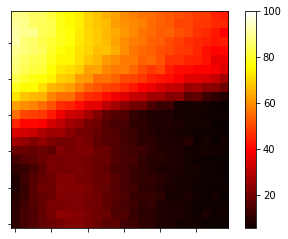

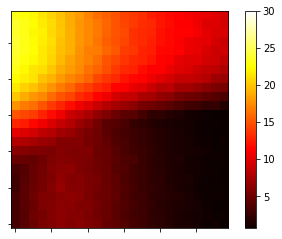

In [15]:
plt.figure()
plt.imshow(mmxsdfs,cmap="hot",vmax=100)
ax= plt.gca()
ax.invert_yaxis()
ax.set_xticks(range(0,24,4))
ax.set_xticklabels([])
ax.set_yticks(range(0,24,4))
ax.set_yticklabels([])
plt.colorbar()
plt.savefig("mix_max_map.png",dpi=300)
plt.figure()
plt.imshow(mmnsdfs,cmap="hot",vmax=30)
ax= plt.gca()
ax.invert_yaxis()
ax.set_xticks(range(0,24,4))
ax.set_xticklabels([])
ax.set_yticks(range(0,24,4))
ax.set_yticklabels([])
plt.colorbar()
plt.savefig("mix_mean_map.png",dpi=300)

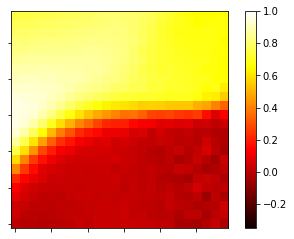

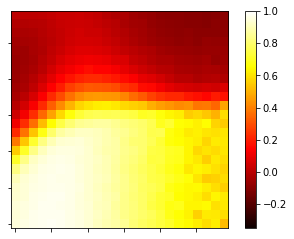

In [14]:
odors= np.load(label+"_odors.npy")
o1= 5
o2= 99
c= np.zeros((cnum,cnum))
for o in [o1, o2]:
    for i in range(cnum):
        for j in range(cnum):
            c[i,j]= np.corrcoef(np.reshape(aimn[i,j,:],-1),np.reshape(odors[o,:,0],-1))[0,1]

    plt.figure()
    plt.imshow(c,cmap="hot",vmin=-0.35, vmax= 1.0)
    plt.gca().invert_yaxis()
    plt.colorbar()
    ax= plt.gca()
    ax.set_xticks(range(0,24,4))
    ax.set_xticklabels([])
    ax.set_yticks(range(0,24,4))
    ax.set_yticklabels([])
    plt.savefig("odor_"+str(o)+"_correl.png", dpi=300)